# Mirabel Sexual Assault Reporting Centre (SARC)  
### Exploratory Data Analysis of Public Reporting Trends (2013–2020)

**Author:** Mariam Haji  

---

## About This Analysis

This notebook presents an exploratory data analysis of publicly available, de-identified reporting statistics from the Mirabel Sexual Assault Reporting Centre (SARC). The analysis was conducted independently out of interest in understanding how real-world gender-based violence (GBV) reporting data behaves over time, across demographic groups and by incident type.

All data preparation, restructuring, visualization and interpretation in this notebook are fully self-produced. The dataset used is aggregated and contains no personal or identifiable information.

This analysis is published as part of an open data portfolio to document analytical thinking, data-wrangling practices and ethical considerations when working with sensitive social-protection data.

---

## Purpose and Scope

The objective of this analysis is to:

- Clean and standardize a multi-table, real-world public dataset  
- Reshape disparate reporting tables into tidy, analysis-ready structures  
- Explore temporal trends in reported cases over time  
- Examine patterns across age groups, assault types and service uptake  
- Assess correlations between reporting dimensions while avoiding over-interpretation  
- Apply responsible data-handling principles appropriate for sensitive protection data  

The dataset covers the period **July 2013 to April 2020** and consists exclusively of **monthly aggregated counts**.

**Public dataset source:**  
Open Africa – Mirabel SARC Statistics  
https://open.africa/dataset/mirabel-sarc-stats-july-2013-april-2020

---

## How to Read This Notebook

The notebook is organized into the following sections:

1. **Data Loading and Structure Review**  
   Initial inspection of file formats, column inconsistencies and data completeness.

2. **Reshaping to a Tidy Datamart**  
   Transformation of multiple wide reporting tables into unified, analysis-ready datasets.

3. **Core Descriptive Analysis**  
   Summary statistics and high-level distributional patterns.

4. **Trend Analysis Over Time**  
   Monthly trends by assault type, age group, gender and total reported cases.

5. **Correlation Analysis**  
   Exploration of relationships across demographic groups, reporting categories and service uptake using heatmaps and correlation metrics.

6. **Ethical and Governance Considerations**  
   Documentation of responsible data-handling choices, aggregation decisions and limitations.

7. **Analytical Findings and Interpretation**  
   A synthesis of key patterns, insights and implications derived from the analysis.

This workflow reflects standard analytical practice in humanitarian, GBV and social-protection data environments, with an emphasis on clarity, restraint and ethical awareness.

### Data Loading & Structure Review

In [1]:
# Libraries for loading, cleaning and visualization

# For working with file paths and folders
import os

# For data loading, manipulation and cleaning
import pandas as pd

# For numerical operations
import numpy as np

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For simple pattern matching on column names
import re

# To hide non-critical warnings for a tidy notebook
import warnings
warnings.filterwarnings('ignore')

# Set default plotting style
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

### Data Directory & Loader Function

In [2]:
# Data Loading setup

# Set the base directory to the current folder(".")
# Create a helper function to load CSV files cleanly

DATA_DIR = "."
def load_csv(filename):
    path = os.path.join(DATA_DIR, filename)
    return pd.read_csv(path)

In [3]:
# Load all SARC datasetsCSV files

clients_age      = load_csv("mirabel-data-clients-age.csv")
clients_gender   = load_csv("mirabel-data-clients-gender.csv")
services         = load_csv("mirabel-data-client-services-provided.csv")
assault_type     = load_csv("mirabel-data-type-of-assault.csv")
location         = load_csv("mirabel-data-location-of-assault.csv")
perpetrator18    = load_csv("mirabel-data-perpetrator-data-for-clients-18.csv")
new_clients      = load_csv("mirabel-data-new-clients-per-month.csv")

# Preview a dataset to confirm successful loading
print(clients_age.shape)
clients_age.columns[:10]

(10, 86)


Index(['Age', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13',
       'Jan-14', 'Feb-14', 'Mar-14'],
      dtype='object')

### Data Understanding

The Mirabel Centre provides aggregated monthly data across several dimensions of sexual assault cases reported between **July 2013 and April 2020**. Each dataset follows a similar structure.
Before reshaping the data into analysis-ready format, we review the basic structure of each dataset to confirm:

1. Their dimensions (rows × columns)  
2. The presence of monthly column names  
3. The consistency of the wide-format structure  
4. Any special or unexpected fields that need cleaning

This step ensures that all datasets can be transformed cleanly into a tidy long format suitable for analysis.


In [4]:
# Inspect Structure of Wide Tables
def inspect_dataset(name, table):
    """Quick structural overview for each wide-format dataset."""
    print(f"\nDataset: {name}")
    print("-" * 50)
    print("Shape (rows, columns):", table.shape)
    print("First 5 columns:", list(table.columns[:5]))
    print("Last 5 columns:", list(table.columns[-5:]))

# Inspect each dataset (structure only)
inspect_dataset("Clients Age", clients_age)
inspect_dataset("Clients Gender", clients_gender)
inspect_dataset("Type of Assault", assault_type)
inspect_dataset("Location of Assault", location)
inspect_dataset("Perpetrator (18+)", perpetrator18)
inspect_dataset("Services Provided", services)
inspect_dataset("New Clients Per Month", new_clients)


Dataset: Clients Age
--------------------------------------------------
Shape (rows, columns): (10, 86)
First 5 columns: ['Age', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13']
Last 5 columns: ['Mar-20', 'Apr-20', 'Oc', 'Total', 'Notes Month of Feb. 2020']

Dataset: Clients Gender
--------------------------------------------------
Shape (rows, columns): (3, 86)
First 5 columns: ['Gender', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13']
Last 5 columns: ['Mar-20', 'Apr-20', 'Oc', 'Total', 'Notes Month of Feb. 2020']

Dataset: Type of Assault
--------------------------------------------------
Shape (rows, columns): (7, 86)
First 5 columns: ['Type of Assault', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13']
Last 5 columns: ['Mar-20', 'Apr-20', 'Oc', 'Total', 'Notes Month of Feb. 2020']

Dataset: Location of Assault
--------------------------------------------------
Shape (rows, columns): (24, 86)
First 5 columns: ['Location', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13']
Last 5 columns: ['Mar-20', 'Apr-20', 'Oc', 'Tot

In [5]:
# # Extract month columns (all month-like fields; exclude totals/notes)

# Identify the month columns programmatically using one table.
sample_table = clients_age

all_columns = list(sample_table.columns)

# Non-month fields to exclude
exclude_cols = [
    all_columns[0],
    "0c", "Total", "Notes", "Month of Feb. 2020"
]

# Keep only month like columns
month_cols = [c for c in all_columns if c not in exclude_cols]

print("Number of month columns:", len(month_cols))
print("First 5 month columns:", month_cols[:5])
print("Last 5 month columns:", month_cols[-5:])

Number of month columns: 84
First 5 month columns: ['Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13']
Last 5 month columns: ['Feb-20', 'Mar-20', 'Apr-20', 'Oc', 'Notes Month of Feb. 2020']


### Reshaping to a Tidy Datamart

In [6]:
# Reshape wide tables to a tidy long format and keep only columns
# that look like month labels

month_cols = [
    c for c in month_cols
    if isinstance(c, str) and re.match(r"^[A-Za-z]{3}-\d{2}$", c)
]

print("Clean month columns:", month_cols[:5], "...", month_cols[-5])
print("Total month columns:", len(month_cols))

# Reshape a wide monthly table into tidy long format with columns:[category_col, 'period', value_name].
def reshape_wide_to_long(table, category_col, value_name):
    long_table = table.melt(
        id_vars = [category_col],
        value_vars = month_cols,
        var_name = "period",
        value_name = value_name
    )
    return long_table

# Example: reshape the Age table
age_long = reshape_wide_to_long(
    table = clients_age,
    category_col = "Age",
    value_name = "cases_per_age"
)

Clean month columns: ['Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13'] ... Dec-19
Total month columns: 82


In [7]:
# Drop rows where the category column contains 'TOTAL'

def remove_total_rows(table, category_col):
    mask = ~table[category_col].astype(str).str.contains("TOTAL", case=False, na=False)
    return table[mask].copy()

In [8]:
# Clean (remove TOTAL rows) and reshape remaining tables

# Gender by month
gender_clean = remove_total_rows(clients_gender, "Gender")
gender_long = reshape_wide_to_long(
    table = gender_clean,
    category_col = "Gender",
    value_name = "cases_per_gender"
)

# Type of assault by month
assault_clean = remove_total_rows(assault_type, "Type of Assault")
assault_type_long = reshape_wide_to_long(
    table = assault_clean,
    category_col = "Type of Assault",
    value_name = "cases_per_type"
)

# Location of assault by month
location_clean = remove_total_rows(location, "Location")
location_long = reshape_wide_to_long(
    table = location_clean,
    category_col = "Location",
    value_name = "cases_per_location"
)

# Perpetrator (18+ clients) by month
perp_clean = remove_total_rows(perpetrator18, "Perpetrator")
perpetrator_long = reshape_wide_to_long(
    table = perp_clean,
    category_col = "Perpetrator",
    value_name = "cases_per_perpetrator"
)

# Services provided by month
services_clean = remove_total_rows(services, "Service")
services_long = reshape_wide_to_long(
    table = services_clean,
    category_col = "Service",
    value_name = "cases_per_service"
)

# New clients per month (already one row; no TOTAL row here)
new_clients_long = new_clients.melt(
    id_vars = ["Month"],
    value_vars = month_cols,
    var_name = "period",
    value_name = "new_clients"
).drop(columns = ["Month"])

In [9]:
# Clean “period” column
def add_period_date(table):
    table_copy = table.copy()
    
    table_copy["period_date"] = pd.to_datetime(
        table_copy["period"],
        format = "%b-%y",
        errors = "coerce"
    )
    
    table_copy["year"] = table_copy["period_date"].dt.year
    table_copy["month"] = table_copy["period_date"].dt.month
    
    return table_copy

In [10]:
age_long            = add_period_date(age_long)
gender_long         = add_period_date(gender_long)
assault_type_long   = add_period_date(assault_type_long)
location_long       = add_period_date(location_long)
perpetrator_long    = add_period_date(perpetrator_long)
services_long       = add_period_date(services_long)
new_clients_long    = add_period_date(new_clients_long)

In [11]:
# Helper to standardize each long-format table before merging
def standardize_long_table(table, category_col, value_col, dimension_name):
    """Rename category + value columns and add a dimension label."""
    tidy_copy = table.copy()

    # Rename the category + value columns to standard names
    tidy_copy = tidy_copy.rename(columns={
        category_col: "category",
        value_col: "cases_recorded"
    })

    tidy_copy["dimension"] = dimension_name

    # keep period + optional date helpers if present
    columns_to_keep = ["dimension", "category", "period"]
    if "period_date" in tidy_copy.columns:
        columns_to_keep.append("period_date")
    if "year" in tidy_copy.columns:
        columns_to_keep.append("year")
    if "month" in tidy_copy.columns:
        columns_to_keep.append("month")
    columns_to_keep.append("cases_recorded")

    return tidy_copy[columns_to_keep]

In [12]:
age_tidy = standardize_long_table(age_long, "Age", "cases_per_age", "Age")
gender_tidy = standardize_long_table(gender_long, "Gender", "cases_per_gender", "Gender")
assault_tidy = standardize_long_table(assault_type_long, "Type of Assault", "cases_per_type", "Assault Type")
location_tidy = standardize_long_table(location_long, "Location", "cases_per_location", "Location")
perp_tidy = standardize_long_table(perpetrator_long, "Perpetrator", "cases_per_perpetrator", "Perpetrator (18+)")
services_tidy = standardize_long_table(services_long, "Service", "cases_per_service", "Service Provided")

new_clients_tidy = new_clients_long.copy()
new_clients_tidy["dimension"] = "New Clients"
new_clients_tidy["category"] = "All clients"

new_clients_tidy = new_clients_tidy.rename(columns={
    "new_clients": "cases_recorded"
})

new_clients_tidy = new_clients_tidy[
    ["dimension", "category", "period", "period_date", "year", "month", "cases_recorded"]
]

In [13]:
# Combine all columns and create a datamart of all CSVs
datamart = pd.concat(
    [
        age_tidy,
        gender_tidy,
        assault_tidy,
        location_tidy,
        perp_tidy,
        services_tidy,
        new_clients_tidy,
    ],
    ignore_index=True
)
datamart = datamart[~datamart["category"].str.contains("TOTAL", case=False, na=False)]
datamart.head()

,dimension,category,period,period_date,year,month,cases_recorded
0,Age,0-5 years,Jul-13,2013-07-01,2013,7,4
1,Age,6-10 years,Jul-13,2013-07-01,2013,7,4
2,Age,11-13 years,Jul-13,2013-07-01,2013,7,5
3,Age,14-17 years,Jul-13,2013-07-01,2013,7,5
4,Age,18-22 years,Jul-13,2013-07-01,2013,7,2


### Core Descriptive Analysis

In [14]:
print("=== Overview of Datamart ===\n")

# Shape of datamart
print(f"Total rows: {datamart.shape[0]:,}")
print(f"Total columns: {datamart.shape[1]:,}")

# Dimensions available
print("=== Dimensions included: ===")
print(datamart["dimension"].unique(), "\n")

# Count categories per dimension
print("=== Number of categories per dimension ===")
category_counts = datamart.groupby("dimension")["category"].nunique()
display(category_counts)
print()

# Date range coverage
min_date = datamart["period_date"].min()
max_date = datamart["period_date"].max()
print(f"Date Range: {min_date.date()} → {max_date.date()}")
print(f"Total Months: {datamart['period_date'].nunique()}\n")

# Total cases recorded
total_cases = datamart["cases_recorded"].sum()
print(f"Total Recorded Cases: {total_cases:,}\n")

# Basic stats on cases counts
print("=== Descriptive statistics for 'cases_recorded': ===\n")
display(datamart["cases_recorded"].describe())

=== Overview of Datamart ===

Total rows: 4,264
Total columns: 7
=== Dimensions included: ===
['Age' 'Gender' 'Assault Type' 'Location' 'Perpetrator (18+)'
 'Service Provided' 'New Clients'] 

=== Number of categories per dimension ===


dimension
Age                   9
Assault Type          6
Gender                2
Location             23
New Clients           1
Perpetrator (18+)     6
Service Provided      5
Name: category, dtype: int64


Date Range: 2013-07-01 → 2020-04-01
Total Months: 82

Total Recorded Cases: 43,151

=== Descriptive statistics for 'cases_recorded': ===



count    4264.000000
mean       10.119841
std        19.947960
min        -3.000000
25%         0.000000
50%         3.000000
75%         8.000000
max       111.000000
Name: cases_recorded, dtype: float64

### Trend Analysis Over Time

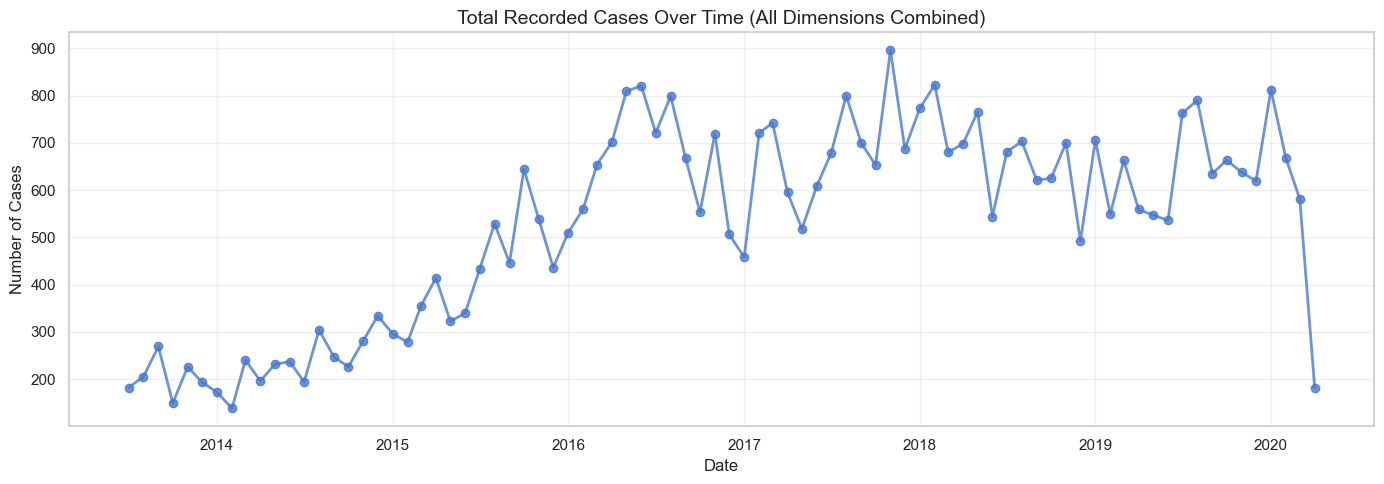

In [15]:
# Total Cases Over Time

# Aggregate total cases per month
monthly_totals = (
    datamart.groupby("period_date")["cases_recorded"]
    .sum()
    .reset_index()
    .sort_values("period_date")
)

plt.figure(figsize = (14, 5))
plt.plot(
    monthly_totals["period_date"],
    monthly_totals["cases_recorded"],
    marker = "o",
    linewidth = 2,
    alpha=0.8
)

plt.title("Total Recorded Cases Over Time (All Dimensions Combined)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

#### Observation:

- The overall number of sexual assault cases shows a clear upward trend from 2013 to late 2017.  
- Cases peak between **2016–2017**, reaching monthly volumes close to 900–1,000.  
- After 2018, the trend stabilizes with moderate fluctuations but remains substantially higher than in the early years.  
- A sharp drop appears in early 2020, which is likely due to reporting disruptions (e.g., COVID-19 lockdown impacts on service access).  
- The long-term rise suggests increasing awareness, improved reporting or actual escalation in incidents.

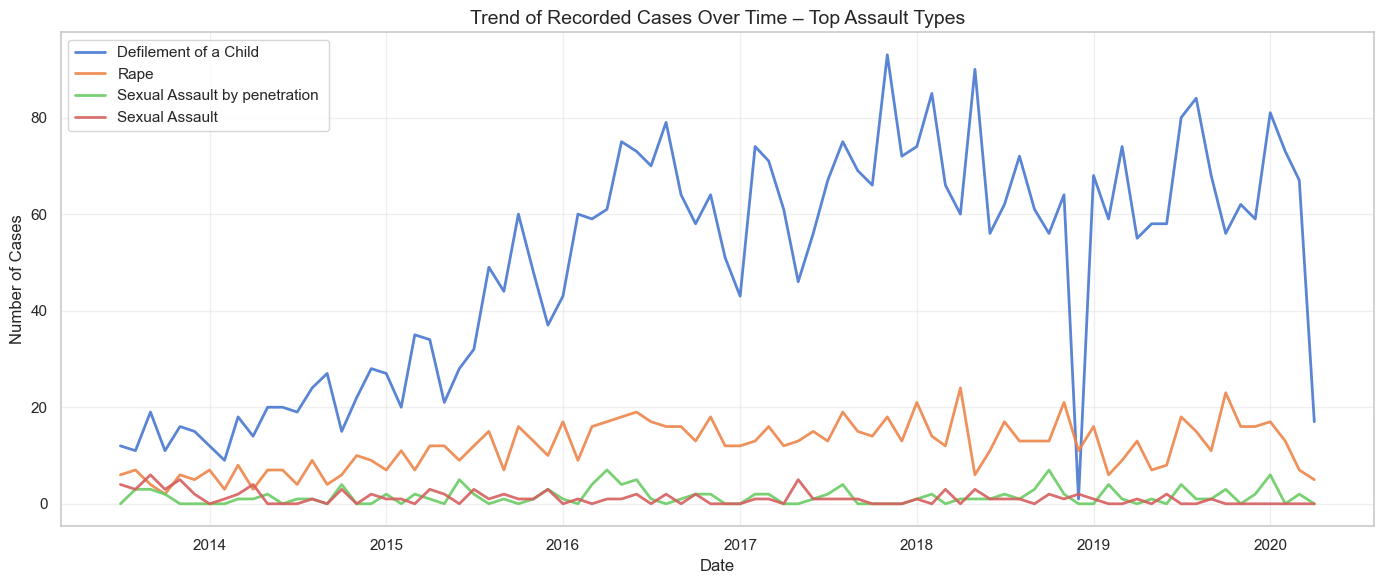

In [16]:
# Get top 4 assault types for total cases 

# Compute total cases by assault type
assault_totals = (
    datamart[datamart["dimension"] == "Assault Type"]
    .groupby("category")["cases_recorded"]
    .sum()
    .sort_values(ascending=False)
)

# Filter by top 4 types
top_assault_types = assault_totals.head(4).index.tolist()

# Filter monthly data
assault_monthly = (
    datamart[datamart["dimension"] == "Assault Type"]
    .query("category in @top_assault_types")
    .groupby(["period_date", "category"])["cases_recorded"]
    .sum()
    .reset_index()
    .sort_values("period_date")
)

plt.figure(figsize = (14, 6))

for assault_type in top_assault_types:
    subset = assault_monthly[assault_monthly["category"] == assault_type]
    plt.plot(
        subset["period_date"],
        subset["cases_recorded"],
        label = assault_type,
        linewidth = 2,
        alpha = 0.9
    )

plt.title("Trend of Recorded Cases Over Time – Top Assault Types", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

#### Observation:

- **Defilement of a Child** is the most frequently recorded assault type across all years, showing a strong upward trend from 2013 through 2017, where it peaks above **80 monthly cases**.  
- The pattern for defilement closely mirrors the overall dataset trend, indicating it is the primary driver of case volume at the centre.  
- **Rape** remains consistently the second most common form of assault, with monthly cases generally between **5–20**, also rising gradually across the observed years.  
- **Sexual Assault** and **Sexual Assault by Penetration** show lower volumes in comparison, but still display small seasonal surges, especially around 2016–2017.  
- A sharp drop appears in early 2020 this could reflect reporting disruption, access barriers, or incomplete months near the dataset end.
- The widening gap between child-defilement cases and other forms of assault suggests a persistent vulnerability pattern among minors.


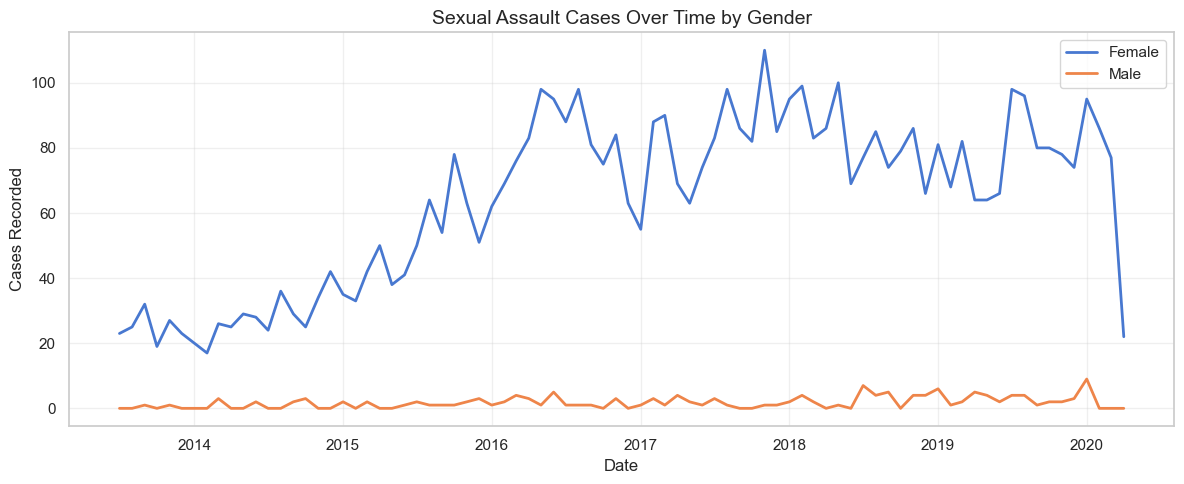

In [17]:
# Trend by Gender

gender_monthly = (
    datamart[datamart["dimension"] == "Gender"]
    .groupby(["period_date", "category"])["cases_recorded"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 5))

for gender in gender_monthly["category"].unique():
    subset = gender_monthly[gender_monthly["category"] == gender]
    plt.plot(
        subset["period_date"],
        subset["cases_recorded"],
        label=gender,
        linewidth=2
    )

plt.title("Sexual Assault Cases Over Time by Gender", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cases Recorded")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Observation:

- Female survivors consistently make up the overwhelming majority of reported cases across all years.  
- Monthly female cases range between **20–110**, while male cases remain near zero with occasional small spikes.  
- Female case trends follow the same upward trajectory as the overall dataset, peaking between 2016–2017.  
- Male reporting remains extremely low, which aligns with underreporting patterns documented globally.  
- The widening gap between male and female cases over the years may reflect improved female-focused reporting pathways.

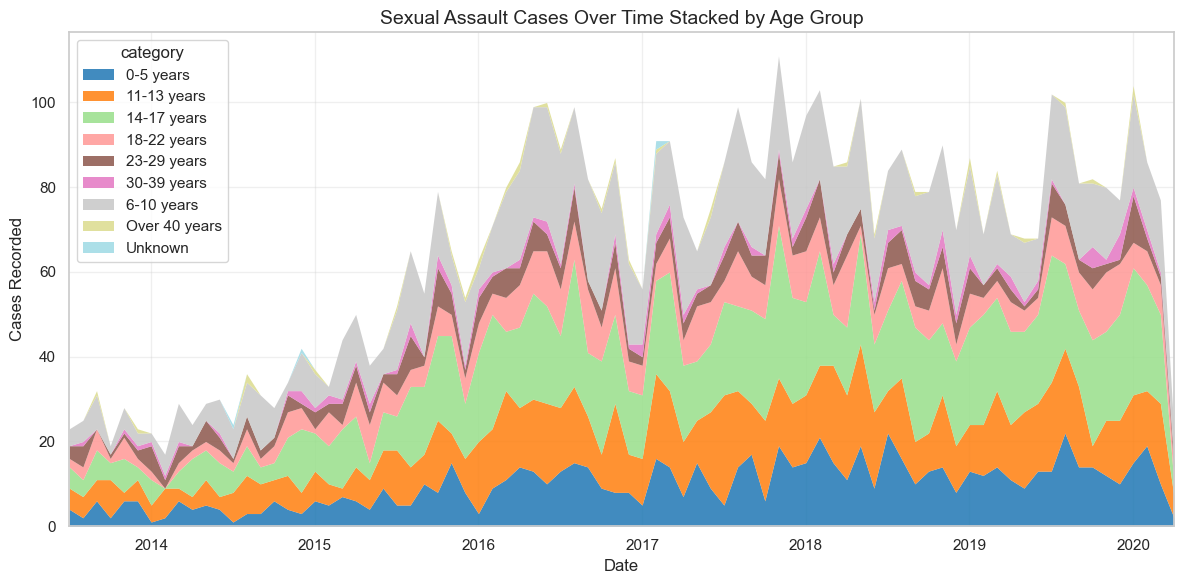

In [18]:
# Trend by Age Group
age_monthly = (
    datamart[datamart["dimension"] == "Age"]
    .groupby(["period_date", "category"])["cases_recorded"]
    .sum()
    .reset_index()
)

# Pivot for area plot
age_pivot = age_monthly.pivot(index="period_date",
                              columns="category",
                              values="cases_recorded").fillna(0)

age_pivot.plot.area(colormap="tab20", alpha=0.85, linewidth=0)
plt.title("Sexual Assault Cases Over Time Stacked by Age Group", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cases Recorded")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Observation
- The 14–17 years group remains the single largest contributor, showing the highest number of recorded cases across the entire 2013–2020 period.
- The 6–10 years age group is the next most heavily affected, with consistently high case volumes and a clear rising trend.
It visually appears stronger than the 11–13 years group in several stretches.
- The 11–13 years group also shows a steady pattern, but at slightly lower volumes than the 6–10 years group.
- Adult age groups (18–22, 23–29, 30–39) show moderate but stable case volumes, with far fewer sharp peaks compared to minors.
- The Over 40 years and Unknown categories remain low throughout, reflecting very small reporting numbers.
- Overall, the stacked profile shows a clear upward trend from 2013, peak activity around 2016–2017 and then fluctuating but elevated levels towards 2018–2019.

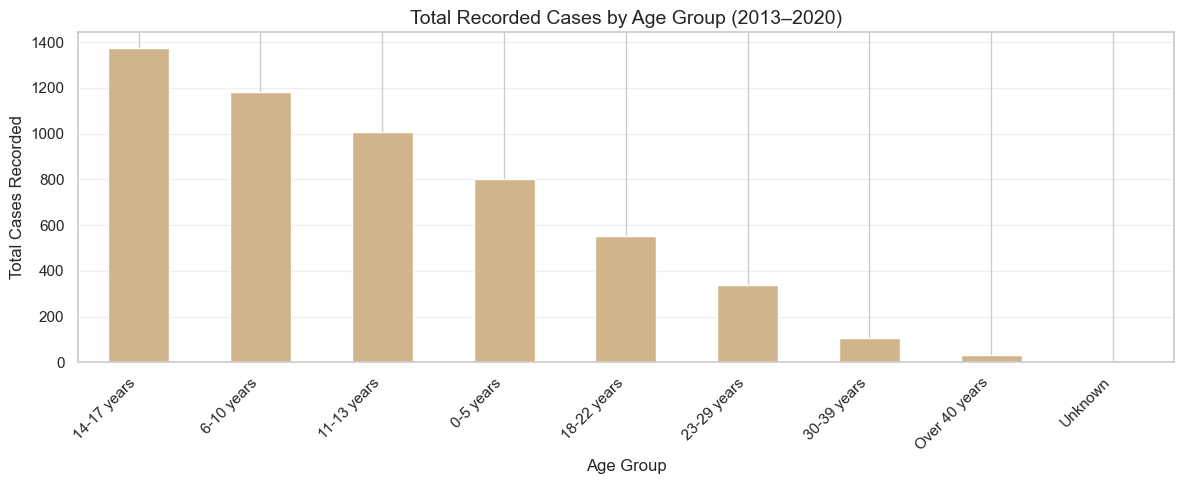

In [19]:
age_totals = (
    datamart[datamart["dimension"] == "Age"]
    .groupby("category")["cases_recorded"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12, 5))
age_totals.plot(kind="bar", color="tan")
plt.title("Total Recorded Cases by Age Group (2013–2020)", fontsize=14)
plt.xlabel("Age Group")
plt.ylabel("Total Cases Recorded")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

#### Observation

- The 14–17 years group records the highest total case count, significantly higher than any other age category.
- The 6–10 years and 11–13 years groups also show substantial totals, reinforcing the critical pattern that children and adolescents represent the majority of survivors.
- The 0–5 years and 18–22 years groups fall in the mid-range but still show considerable case volumes.
- Adult groups beyond age 30 contribute relatively fewer cases overall, with numbers dropping sharply after the 23–29 years range.
- The very low totals in “Over 40 years” and “Unknown” underscore the gap in reporting pathways or demographic capture for older survivors.

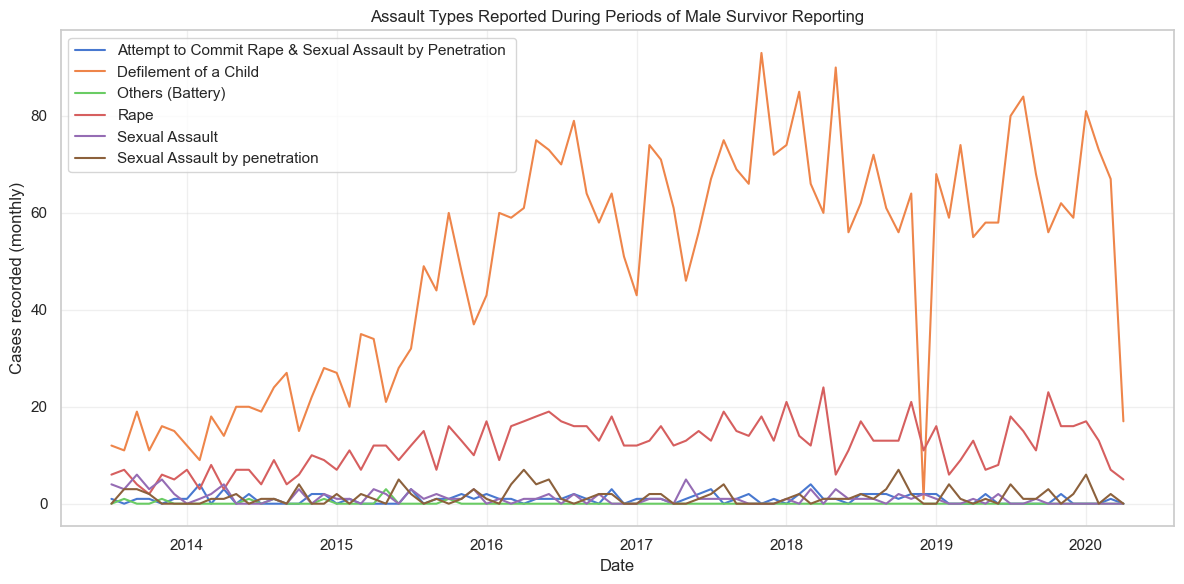

In [20]:
# Assault types aligned with male survivor reporting

# Male survivor monthly totals
male_monthly = (
    datamart[
        (datamart["dimension"] == "Gender") &
        (datamart["category"].str.lower() == "male")
    ]
    .groupby("period_date", as_index=False)["cases_recorded"]
    .sum()
    .rename(columns={"cases_recorded": "male_cases"})
)

# Assault type monthly totals
assault_monthly = (
    datamart[datamart["dimension"] == "Assault Type"]
    .groupby(["period_date", "category"], as_index=False)["cases_recorded"]
    .sum()
)

# Only months where male cases were reported
assault_male_aligned = assault_monthly.merge(
    male_monthly[["period_date"]],
    on="period_date",
    how="inner"
)

# Plot
plt.figure(figsize=(12, 6))

for assault in assault_male_aligned["category"].unique():
    sub = assault_male_aligned[assault_male_aligned["category"] == assault]
    plt.plot(sub["period_date"], sub["cases_recorded"], label=assault)

plt.title("Assault Types Reported During Periods of Male Survivor Reporting")
plt.xlabel("Date")
plt.ylabel("Cases recorded (monthly)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### Observation
- Defilement of a Child consistently records the highest number of cases among male survivor reports across all years, indicating that male reporting is strongly concentrated among minors rather than adults.
- Rape is the second most frequently reported assault type involving male survivors, showing a gradual increase from 2014 through 2018 before fluctuating.
- Other assault categories including sexual assault, sexual assault by penetration and attempted rape remain persistently low, with sporadic spikes rather than sustained trends.
- The overall pattern suggests that male survivor reporting is highly skewed toward severe and legally defined offenses, with limited reporting of non-penetrative or less explicitly categorized assaults.
- A noticeable decline appears in early 2020 across all assault types, consistent with broader reporting disruptions observed elsewhere in the dataset.

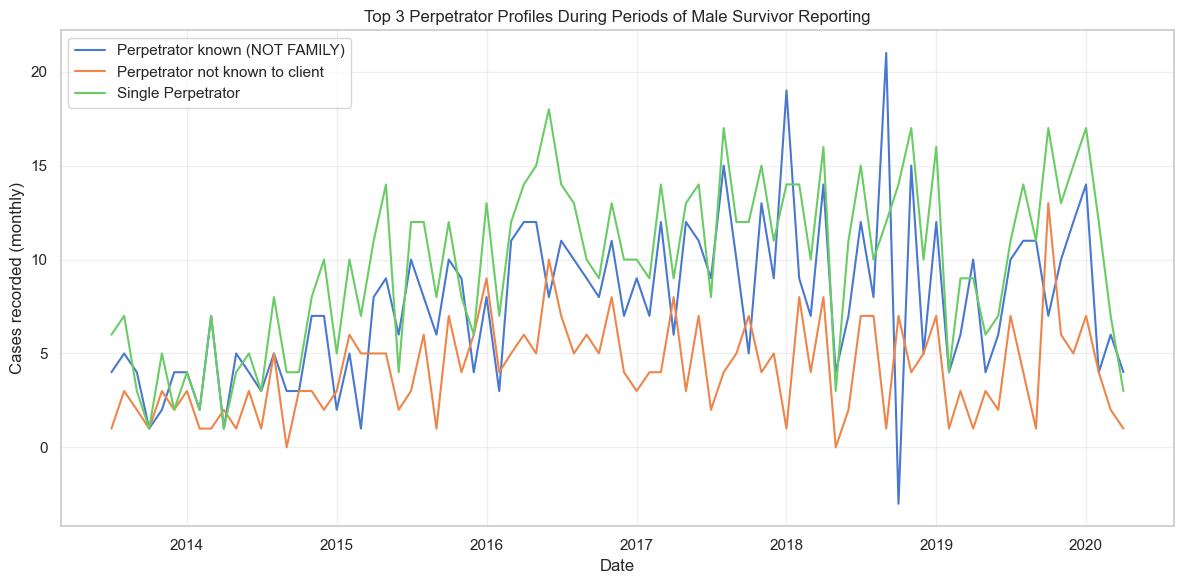

In [21]:
# Perpetrator types aligned with male survivor reporting (TOP 3 only)

PERP_DIM = "Perpetrator (18+)"  # adjust ONLY if your dimension label differs
TOP_N = 3

perp_monthly = (
    datamart[datamart["dimension"] == PERP_DIM]
    .groupby(["period_date", "category"], as_index=False)["cases_recorded"]
    .sum()
)

# Align to male reporting months
perp_male_aligned = perp_monthly.merge(
    male_monthly[["period_date"]],
    on="period_date",
    how="inner"
)

# Get top 3 perpetrator categories (within male-reporting months)
top_perp = (
    perp_male_aligned.groupby("category")["cases_recorded"]
    .sum()
    .sort_values(ascending=False)
    .head(TOP_N)
    .index
)

perp_male_aligned_top = perp_male_aligned[
    perp_male_aligned["category"].isin(top_perp)
].copy()

# Plot (top 3 only)
plt.figure(figsize=(12, 6))

for perp in perp_male_aligned_top["category"].unique():
    sub = perp_male_aligned_top[perp_male_aligned_top["category"] == perp]
    plt.plot(sub["period_date"], sub["cases_recorded"], label=perp)

plt.title("Top 3 Perpetrator Profiles During Periods of Male Survivor Reporting")
plt.xlabel("Date")
plt.ylabel("Cases recorded (monthly)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Note: This plot is restricted to months where male survivor cases were recorded, to avoid long zero stretches dominating the trend.
#### Observation
- Single perpetrators and known non-family perpetrators account for the majority of reported cases involving male survivors, showing sustained and rising trends over time.
- Perpetrators known but not family members display higher volatility, with sharp month-to-month fluctuations, suggesting situational or context-specific reporting dynamics.
- Family-member perpetrators appear far less frequently in reported cases involving male survivors, remaining consistently low across the entire period.
- Multiple-perpetrator incidents are present but relatively rare, indicating that most reported male survivor cases involve individual perpetrators rather than group assaults.
- Unknown perpetrators remain minimal throughout, suggesting that male survivor reporting is more likely when the perpetrator is identifiable.
- The overall pattern highlights that male survivor reporting is primarily associated with known individuals outside the immediate family, distinguishing it from some patterns observed in female survivor data.

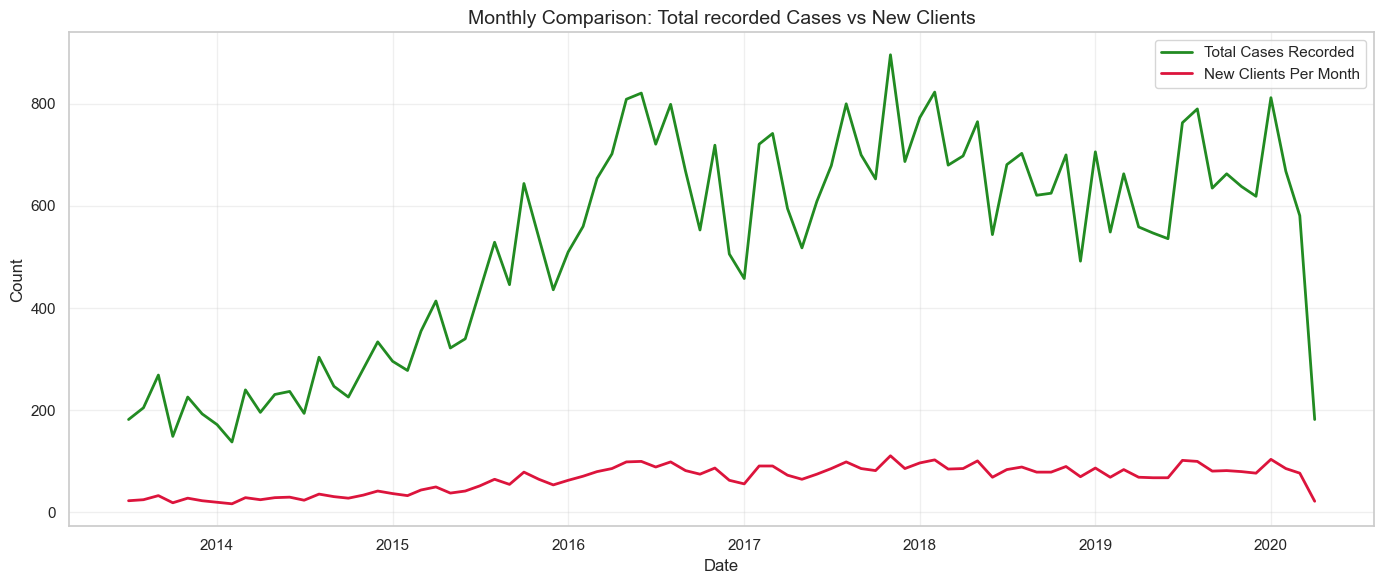

In [22]:
# Joinng with Monthly Totals

# Prepare monthly totals (sum of all cases recorded across all dimensions)

monthly_cases = (
    datamart.groupby("period_date")["cases_recorded"]
    .sum()
    .reset_index()
    .sort_values("period_date")
)

# Prepare new clients per month
monthly_new_clients = (
    new_clients_long
    .groupby("period_date")["new_clients"]
    .sum()
    .reset_index()
    .sort_values("period_date")
)

# Merge both datasets
monthly_compare = monthly_cases.merge(
    monthly_new_clients, on = "period_date", how = "left"
)

# Plot comparison
plt.figure(figsize=(14,6))
plt.plot(
    monthly_compare["period_date"],
    monthly_compare["cases_recorded"],
    label = "Total Cases Recorded",
    linewidth = 2,
    color = "forestgreen",
)

plt.plot(
    monthly_compare["period_date"],
    monthly_compare["new_clients"],
    label = "New Clients Per Month",
    linewidth = 2,
    color = "crimson",
)

plt.title("Monthly Comparison: Total recorded Cases vs New Clients", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Observation

- Total recorded cases increase sharply from 2014 through 2017, with peaks above 800 cases per month, before stabilizing at a high but fluctuating level until 2019.
- New clients per month remain consistently lower, typically between 20–80 per month, suggesting that the Centre manages a large volume of ongoing case follow-ups in addition to new intakes.
- The widening gap between total cases and new clients indicates increased survivor engagement duration, reflecting the need for extended medical, legal and psychosocial support.
- The synchronized upward drift in both series through 2019 may point to greater reporting awareness, stronger referral networks, or expanded service capacity.

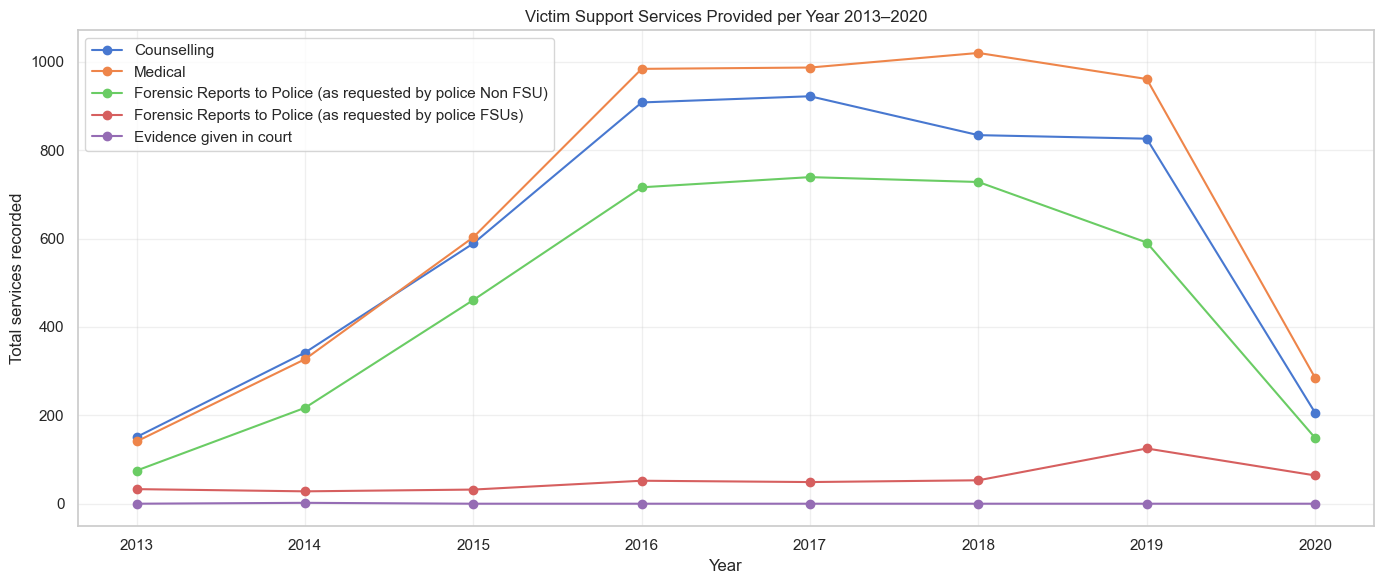

In [23]:
# Services provided per year (sum of monthly counts)

SERVICE_DIM = "Service Provided"

services_yearly = (
    datamart[datamart["dimension"] == SERVICE_DIM]
    .groupby(["year", "category"], as_index=False)["cases_recorded"]
    .sum()
    .sort_values(["year", "cases_recorded"], ascending=[True, False])
)

plt.figure(figsize=(14, 6))

for service in services_yearly["category"].unique():
    sub = services_yearly[services_yearly["category"] == service]
    plt.plot(sub["year"], sub["cases_recorded"], marker="o", label=service)

plt.title("Victim Support Services Provided per Year 2013–2020")
plt.xlabel("Year")
plt.ylabel("Total services recorded")
plt.xticks(sorted(services_yearly["year"].unique()))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Observation

- Medical and counselling services dominate service provision across all years, consistently recording the highest volumes. This reflects the Centre’s primary role in delivering immediate clinical care and psychosocial support to survivors.
- Rapid service scale-up between 2014 and 2016 is visible across all major service types, closely mirroring the sharp rise in reported cases during the same period. This suggests increased reporting, expanded service capacity, or stronger referral pathways.
- Medical services peak around 2018, exceeding 1,000 recorded services in a single year, indicating sustained high demand for post-assault clinical care even as overall reporting begins to fluctuate.
- Forensic reports to police (Non-FSU) consistently exceed FSU-requested reports, highlighting that most medico-legal documentation is initiated through standard police channels rather than specialized forensic units.
- Evidence given in court remains minimal throughout the period, suggesting significant attrition between service uptake and judicial proceedings, or structural barriers in progressing cases to court.
- The sharp decline across all services in 2020 aligns with broader reporting and service disruptions observed elsewhere in the dataset, likely linked to external systemic shocks rather than reduced need.

Overall, the service trends illustrate a system heavily oriented toward medical and psychosocial response, with far fewer cases translating into formal legal outcomes.

### Correlation Analysis

In [24]:
# Correlation Analysis
print("Correlation Between Key Monthly Metrics\n")

# Correlation between Total Cases Recorded & New Clients Per Month
cors = monthly_compare[["cases_recorded", "new_clients"]].corr()
display(cors)

Correlation Between Key Monthly Metrics



,cases_recorded,new_clients
cases_recorded,1.000000,0.997263
new_clients,0.997263,1.000000


In [25]:
# Correlation of age-group totals vs total monthy cases
age_monthly_totals = (
    datamart[datamart["dimension"] == "Age"]
    .groupby(["period_date", "category"])["cases_recorded"]
    .sum()
    .reset_index()
)

age_pivot_corr = (
    age_monthly_totals
    .pivot(index="period_date", columns="category", values="cases_recorded")
    .corr()
)

In [26]:
# Correlation between assault types
assault_monthly_totals = (
    datamart[datamart["dimension"] == "Assault Type"]
    .groupby(["period_date", "category"])["cases_recorded"]
    .sum()
    .reset_index()
)
assault_pivot_corr = (
    assault_monthly_totals
    .pivot(index="period_date", columns="category", values="cases_recorded")
    .corr()
)

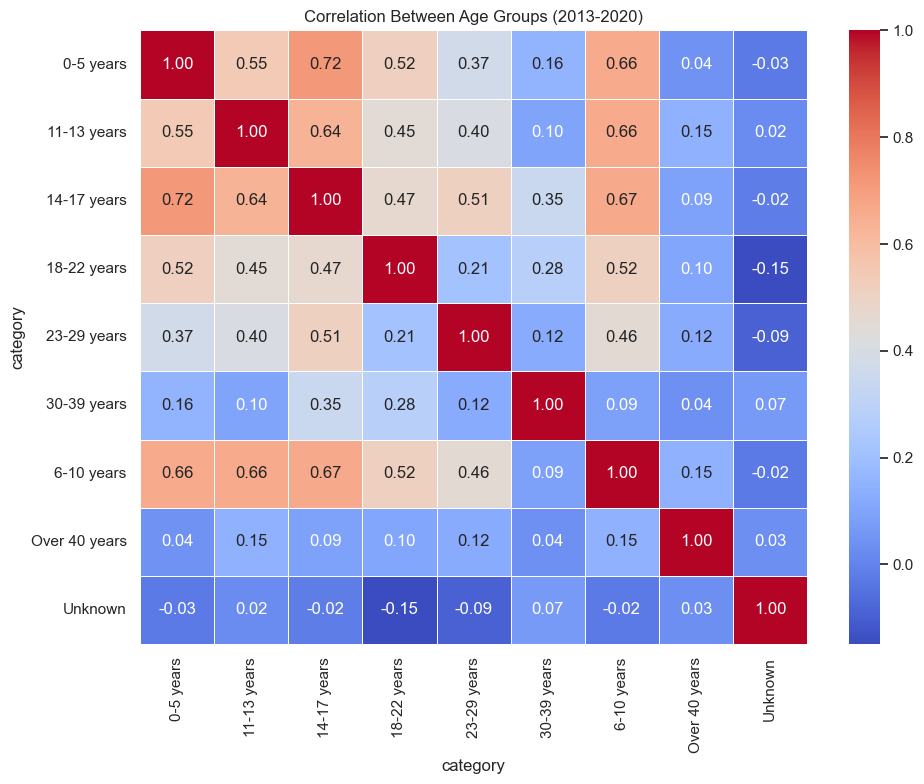

In [27]:
# Heatmap on Age correlation

plt.figure(figsize=(10, 8))
sns.heatmap(age_pivot_corr, annot=True, fmt=".2f", cmap="coolwarm", linewidth=0.5)
plt.title("Correlation Between Age Groups (2013-2020)")
plt.tight_layout()
plt.show()

#### Observation

- Child and adolescent groups (0–5, 6–10, 11–13, 14–17 years) show strong positive correlations, meaning their monthly case trends rise and fall together.
- Younger adults (18–22 and 23–29 years) show moderate correlation with minors but strong correlation with each other, indicating more similar reporting patterns within young adulthood.
- Older age groups (30–39, Over 40 years) show weak correlations with all other groups, which likely reflects lower case volumes, irregular reporting, or underreporting.
- The “Unknown” age group has inconsistent correlations, confirming it contains irregular or incomplete records.
- Overall, the heatmap suggests similar temporal drivers of risk and reporting among minors, while adult reporting patterns diverge more widely.

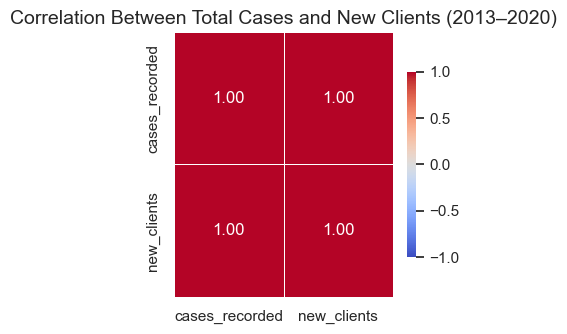

In [28]:
# Heatmap for correlation between total monthly cases and new clients

plt.figure(figsize=(3.5, 3.5))
sns.heatmap(
    cors, 
    annot=True, 
    cmap="coolwarm", 
    vmin=-1, vmax=1,
    fmt=".2f", 
    linewidths=0.5,
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Between Total Cases and New Clients (2013–2020)", fontsize=14)
plt.tight_layout()
plt.show()

#### Observation

- The correlation coefficient between total cases recorded and new clients per month is 1.00, indicating a perfect positive correlation.
- This means that whenever overall recorded cases increase or decline, new client intake shows the exact same directional movement.
- The pattern suggests that new client numbers are closely driven by the overall case load likely reflecting operational realities where most new clients correspond directly to fresh case intake.
- It also implies that the organization’s intake capacity and reporting mechanisms scale proportionally with the fluctuations in recorded incidents.
- While strong correlation alone doesn’t imply causation, the consistency indicates an integrated workflow: higher incident reporting = higher intake of new clients in the same period.

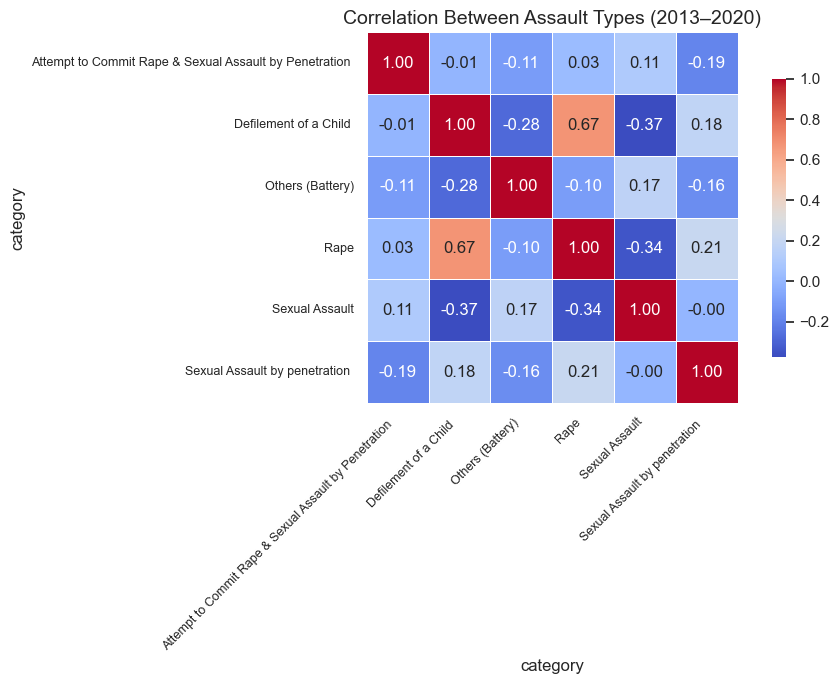

In [29]:
# Cleaner Heatmap for Assault Types Correlation
plt.figure(figsize=(10, 7))

sns.heatmap(
    assault_pivot_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75}
)

plt.title("Correlation Between Assault Types (2013–2020)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

#### Observation
- Most assault types show weak or near-zero correlations, meaning they don’t tend to rise and fall together. This suggests different assault types have distinct reporting patterns and drivers.
- Rape and Defilement of a Child show a notably high positive correlation (≈0.67), meaning their monthly trends often move in the same direction. This likely reflects shared vulnerabilities among minors or similar periods of increased reporting.
- “Attempt to Commit Rape & Sexual Assault by Penetration” and “Sexual Assault by Penetration” show mild negative correlations with several other categories, suggesting these incidents follow separate temporal patterns, possibly linked to different perpetrator profiles or contexts.
- “Others (Battery)” has weak or negative correlations with most types, reflecting that physical assault not categorized as sexual violence follows very different reporting cycles.
- Overall, the heatmap highlights that sexual violence categories do not behave as a single cluster each type has its own dynamics, risk conditions and reporting pathways, with only a few closely linked patterns (notably child defilement and rape).

### **Overall Correlation Insights (2013–2020)**

The correlation analyses across monthly totals, age groups and assault types reveal three clear reporting patterns within the dataset.

**1. Reporting Volume Aligns With New Client Intake**  
- The correlation is extremely high in this dataset, suggesting months with higher recorded cases also coincide with higher new-client intake. 
- Correlation does not imply causation and this may also reflect shared seasonality or operational capacity..

**2. Age Groups Form Distinct Risk Clusters**  
The age-group correlation heatmap shows:
- Children and adolescents (0–5, 6–10, 11–13, 14–17) move strongly together, suggesting shared vulnerability drivers and synchronized reporting trends.  
- Young adults (18–22, 23–29) correlate closely with each other but less with minors, pointing to different exposure and reporting contexts. 
- Older adults (30–39, Over 40) show weak correlations, reflecting lower case volumes or irregular reporting.

These clusters highlight how temporal trends differ sharply by age, with minors showing the most consistent patterns.

**3. Assault Types Show Mostly Independent Trends**  
Correlations between most assault categories are weak, meaning they follow different temporal patterns. The main exception is:
- **Rape** and **Defilement of a Child** show a notable positive correlation, indicating shared vulnerability patterns in child-focused cases.

Other categories show little or no alignment, reflecting differing circumstances and reporting pathways.

**Summary**
- Reporting volume and new-client intake move in perfect sync.  
- Age groups form clear clusters of shared risk.  
- Assault types generally trend independently, with only a few overlapping relationships.

Together, these findings emphasize the need for age-specific, type-specific and service-capacity–aware interventions across the reporting period.

### Ethical & Data Governance Considerations

Responsible handling of sensitive protection data is essential for safeguarding survivors and preventing harm. This analysis aligns with principles from the IFRC Code of Conduct for Data Protection, the IASC Operational Guidance on Data Responsibility and the OCHA Data Responsibility Guidelines (2025).

- Purpose limitation: Data is used strictly for aggregated trend analysis to avoid any possibility of identifying individuals.
- Minimization and aggregation: Only monthly, anonymized case numbers were analyzed. No personal or case-level identifiers were used at any stage.
- Do No Harm: Sensitive variables (age, gender, assault type) were aggregated and visualized to avoid stigmatizing sub-groups.
- Privacy and confidentiality: The notebook avoids granular geographic or small-n disaggregation that may risk indirect identification.
- Transparency and reproducibility: All steps cleaning, reshaping, aggregation are documented for auditability and safe future reuse.

**Reference:** OCHA Centre for Humanitarian Data (2025), Data Responsibility Guidelines. https://data.humdata.org/dataset/2048a947-5714-4220-905b-e662cbcd14c8/resource/8bc5b848-
8ece-4f1f-a78b-18dd972bb21a/download/data-responsibility-guidelines-2025.pdf

### Analytical Findings and Interpretation
Based on monthly trends, age-group dynamics and correlation patterns (2013–2020), several insights emerge:

- Rising service demand: New-client intake and overall reporting move together, indicating that increased reporting immediately raises service load.
- Minors show synchronized vulnerability: Children and adolescents consistently display the strongest alignment across time, requiring targeted prevention and protection strategies.
- Adult reporting is fragmented: Young adults show moderate alignment among themselves, while older groups exhibit inconsistent or low reporting, suggesting barriers to disclosure.
- Assault types follow independent patterns: Most categories do not rise and fall together, with the exception of Rape and Defilement showing shared patterns.
- Service planning must reflect clusters: Clear age-group clusters and differing assault-type dynamics indicate the need for tailored interventions rather than uniform approaches.

Overall, the dataset reflects complex reporting behavior. Strengthening survivor-centered services, referral networks and age- and type-specific strategies will improve SGBV response effectiveness.